## Business Understanding

**StakeHolder**: A **regular investor** who is following financial news on twitter
- The regular investor has been using Bloomberg and other main stream financial news centers to get stock information
- They are looking to get an edge on most investors but are having trouble finding out how
- They decide to go to social media and land on twitter
- However, they are having trouble deciphering whether the tweets are neutral, bullish or bearish
    - In order to know what to buy, sell, short, or keep an eye on for future investments
- This model using a natural language processor to identify whether a tweet is bullish, bearish or neutral can be used for the investors needs on identifying their next big catch in the market before other investors.
- Equally it can make the investor privy to when stocks will potentially plummet


## Data Understanding

- The dataset was found on Hugging Face
- The Twitter Financial News dataset is an English-language dataset containing an annotated corpus of finance-related tweets. 
- This dataset is used to classify finance-related tweets for their sentiment.
- The size of the dataset is roughly 12,000 rows of text
- The data contains two columns; a text column that contains the tweet text and a corresponding label column with a sentiment.
    - Sentiments
         - Label 0: Bearish
         - Label 1: Bullish
         - Label 2: Neutral

In [23]:
# Importing all important packages for modeling
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import set_config
from sklearn.model_selection import GridSearchCV
set_config(display='diagram')
stop_words = stopwords.words('english')
stop_words.append('https')

### Preprocessing the Text Data

In [2]:
# Creating a class that allows text to be preprocessed 
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        # define attributes to store if text preprocessing requires fitting from data
        pass
    
    def fit(self, data, y = 0):
        
        # this is where you would fit corpus specific stopwords
        # fit probable bigrams with bigram model in here
        # save as parameters of Text preprocessor
        return self
    
    def transform(self, data, y = 0):
        normalized_corpus = data.apply(self.process_doc)
        
        return normalized_corpus
        
    def process_doc(self, doc):
        
        # Initialize lemmatizer
        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None
        
        
        # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok.lower() not in stop_words)) ]
        
        # POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
        
        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

In [3]:
# Uploading the necessary train and test data
# The data I used was already split into test and train
train= pd.read_csv('sent_train.csv')
test = pd.read_csv('sent_valid.csv')
X_train = train['text']
X_test = test['text']
y_train = train['label']
y_test = test['label']

In [4]:
# Instantiating the textpreprocessor and fitting/ transforming my X_train
processor = TextPreprocessor()
X_train_transformed = processor.fit_transform(X_train)

In [5]:
# Converting X_train to dataframe so it can be fit in the pipeline
X_train_frame = X_train_transformed.to_frame()

## Modeling

### First Simple Model (FSM) - Complement Naive Bayes

In [6]:
# Creating a pipeline for my model using the complement Naive Bayes because there is a class imbalance
Tweet_text_transformer = Pipeline(steps = [
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ("vec", CountVectorizer()),
    ("array", FunctionTransformer(lambda x: x.toarray()))
])

preprocessor = ColumnTransformer(transformers = [
    ('tweet_text', Tweet_text_transformer, ['text'])])

steps = [('preprocessor', preprocessor), ('ros', RandomOverSampler(random_state = 24, sampling_strategy = 'not majority')), 
         ('compNB', ComplementNB())]

model_pipe = Pipeline(steps)

In [7]:
# fitting the model
model_pipe.fit(X_train_frame, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tweet_text',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001D0A0D68160>)),
                                                                  ('vec',
                                                                   CountVectorizer()),
                                                                  ('array',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001D0C85AAE50>))]),
                                                  ['text'])])),
                ('ros',
                 RandomOverSampler(random_state=24,
                                   sampling_strategy='not majority')),
                ('compNB', ComplementNB())])

In [8]:
# Finding the model train score
model_pipe.score(X_train_frame, y_train)

0.8651367494498585

In [9]:
#Finding the model test score
X_test_transformed = processor.transform(X_test)
X_test_toframe = X_test_transformed.to_frame()
y_pred = model_pipe.predict(X_test_toframe)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.71      0.56       347
           1       0.57      0.68      0.62       475
           2       0.90      0.74      0.81      1566

    accuracy                           0.72      2388
   macro avg       0.64      0.71      0.66      2388
weighted avg       0.77      0.72      0.74      2388



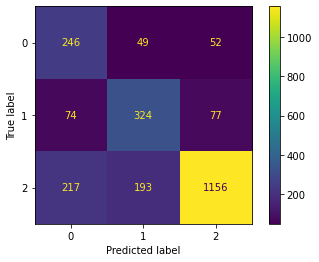

In [10]:
# Plotting a confusion matrix to display the accuracy of my model on the test data
plot_confusion_matrix(model_pipe, X_test_toframe,
                      y_test);

**Based on the models train score and the models test score it seems to be over fitting a little bit. In my next model I am going to hyper parameter tune to see if that helps regularization.**

### Hyper Parameter Tuning the FSM

In [34]:
# Grid searching on the given paramters and instantiating GridSearchCV
gridparams =  [{'compNB__alpha' : [1, .8, .85, .9, .95],
         'ros__sampling_strategy': ['not majority'],
               'preprocessor__tweet_text__vec__max_df': [.95, .8, .7, .6],
               'preprocessor__tweet_text__vec__min_df': [0, .05, .1, .2],
               'preprocessor__tweet_text__vec__ngram_range': [(1,1),(1,2)]}
       ]
GridSearch = GridSearchCV(model_pipe, param_grid = gridparams, scoring= 'f1_weighted', cv = 3)

In [36]:
# Fitting the model to the training data 
GridSearch.fit(X_train_frame, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tweet_text',
                                                                         Pipeline(steps=[('squeeze',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001D135B3BD30>)),
                                                                                         ('vec',
                                                                                          CountVectorizer()),
                                                                                         ('array',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001D135B3BC10>))]),
                                                                         ['text'])])),
                                       ('ros',
                                        RandomOverSampler(random_sta...
                                                          sampling_strategy='not '
                                                                            'majority')),
                                       ('compNB', ComplementNB())]),
             param_grid=[{'compNB__alpha': [1, 0.8, 0.85, 0.9, 0.95],
                          'preprocessor__tweet_text__vec__max_df': [0.95, 0.8,
                                                                    0.7, 0.6],
                          'preprocessor__tweet_text__vec__min_df': [0, 0.05,
                                                                    0.1, 0.2],
                          'preprocessor__tweet_text__vec__ngram_range': [(1, 1),
                                                                         (1,
                                                                          2)],
                          'ros__sampling_strategy': ['not majority']}],
             scoring='f1_weighted')

In [59]:
# The model performed extremely well on the train data
best_model_ComplementNB = GridSearch.best_estimator_
best_model_ComplementNB.score(X_train_frame, y_train)

0.9658388347479828

In [60]:
# However the model did not perform well on the test data
best_model_ComplementNB_pred = best_model_ComplementNB.predict(X_test_toframe)
print(classification_report(y_test, best_model_ComplementNB_pred))

              precision    recall  f1-score   support

           0       0.50      0.70      0.59       347
           1       0.61      0.73      0.66       475
           2       0.90      0.77      0.83      1566

    accuracy                           0.75      2388
   macro avg       0.67      0.73      0.69      2388
weighted avg       0.79      0.75      0.76      2388



**Hyper Paramter tuning the complement Naive Bayes model just made it extremely more overfit. Going to switch over to a different classifier to make it easier to regularize.**

### Random Forest Model

In [98]:
# Using the same pipeline as before by using a Random Forest Classifier
Tweet_text_transformer = Pipeline(steps = [
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ("vec", CountVectorizer()),
    ("array", FunctionTransformer(lambda x: x.toarray()))
])

preprocessor = ColumnTransformer(transformers = [
    ('tweet_text', Tweet_text_transformer, ['text'])])

steps = [('preprocessor', preprocessor), ('ros', RandomOverSampler(random_state = 24, sampling_strategy = 'not majority')), 
         ('rf', RandomForestClassifier(random_state = 24, max_depth = 6))]

rfmodel_pipe = Pipeline(steps)

In [99]:
# Fitting the model on the train data
rfmodel_pipe.fit(X_train_frame, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tweet_text',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001D10483F790>)),
                                                                  ('vec',
                                                                   CountVectorizer()),
                                                                  ('array',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001D10483F700>))]),
                                                  ['text'])])),
                ('ros',
                 RandomOverSampler(random_state=24,
                                   sampling_strategy='not majority')),
                ('rf', RandomForestClassifier(max_depth=6, random_state=24))])

In [100]:
# Model Train score
rfmodel_pipe.score(X_train_frame, y_train)

0.7531174683013727

In [101]:
# Model test score
rf_y_pred = rfmodel_pipe.predict(X_test_toframe)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.50      0.58      0.53       347
           1       0.60      0.59      0.59       475
           2       0.84      0.81      0.82      1566

    accuracy                           0.73      2388
   macro avg       0.64      0.66      0.65      2388
weighted avg       0.74      0.73      0.74      2388



**The train and test scores were similar for the Random Forest model. Aiming to get a better score so I am going to hyper parameter tune the model.**

### Hyper Parameter tuning the RandomForest Model

In [109]:
# Hyper parameter tuning parameters
rfgridparams =  [{'rf__max_depth' : [6,7],
                  'rf__n_estimators' : [100,150, 200],
                 'ros__sampling_strategy': ['not majority'],
               'preprocessor__tweet_text__vec__ngram_range': [(1,1),(1,2)]}]

In [110]:
# Fitting the model to GridSearchCv
RFGridSearch = GridSearchCV(rfmodel_pipe, param_grid = rfgridparams, scoring= 'f1_weighted', cv = 3)

In [111]:
# Fitting on the train data
RFGridSearch.fit(X_train_frame, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('tweet_text',
                                                                         Pipeline(steps=[('squeeze',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001D10483F790>)),
                                                                                         ('vec',
                                                                                          CountVectorizer()),
                                                                                         ('array',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x000001D10483F700>))]),
                                                                         ['text'])])),
                                       ('ros',
                                        RandomOverSampler(random_state=24,
                                                          sampling_strategy='not '
                                                                            'majority')),
                                       ('rf',
                                        RandomForestClassifier(max_depth=6,
                                                               random_state=24))]),
             param_grid=[{'preprocessor__tweet_text__vec__ngram_range': [(1, 1),
                                                                         (1,
                                                                          2)],
                          'rf__max_depth': [6, 7],
                          'rf__n_estimators': [100, 150, 200],
                          'ros__sampling_strategy': ['not majority']}],
             scoring='f1_weighted')

In [112]:
# looking at best parameters
RFGridSearch.best_params_

{'preprocessor__tweet_text__vec__ngram_range': (1, 1),
 'rf__max_depth': 7,
 'rf__n_estimators': 100,
 'ros__sampling_strategy': 'not majority'}

In [113]:
# Assigning best estimator to a variable
RFgridsearch_best_model = RFGridSearch.best_estimator_

In [114]:
# Calculating the score of the best model on the train data
RFgridsearch_best_model.score(X_train_frame, y_train)

0.7637011421984701

In [115]:
# Classification report on the test data
rfgrid_y_pred = RFgridsearch_best_model.predict(X_test_toframe)
print(classification_report(y_test, rfgrid_y_pred))

              precision    recall  f1-score   support

           0       0.49      0.56      0.52       347
           1       0.60      0.61      0.60       475
           2       0.84      0.81      0.83      1566

    accuracy                           0.74      2388
   macro avg       0.64      0.66      0.65      2388
weighted avg       0.74      0.74      0.74      2388



**This model did not do as well as I wanted to so I am going to try a different classifier.**

### XGBoost Classifier

In [12]:
# Creating a pipeline for XGBoost
Tweet_text_transformer = Pipeline(steps = [
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ("vec", CountVectorizer()),
    ("array", FunctionTransformer(lambda x: x.toarray()))
])

preprocessor = ColumnTransformer(transformers = [
    ('tweet_text', Tweet_text_transformer, ['text'])])

steps = [('preprocessor', preprocessor), ('ros', RandomOverSampler(random_state = 24, sampling_strategy = 'not majority')), 
         ('xgb', XGBClassifier(random_state = 24))]

xgbmodel_pipe = Pipeline(steps)

In [13]:
# Fitting to X_train
xgbmodel_pipe.fit(X_train_frame, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tweet_text',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001D0CD2131F0>)),
                                                                  ('vec',
                                                                   CountVectorizer()),
                                                                  ('array',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001D0CD213160>))]),
                                                  ['text'])])),
                ('ros',
                 RandomOverSampler(random_state=24,
                                   sampling_strategy='not...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', random_state=24,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [18]:
# Score on the train data
xgbmodel_pipe.score(X_train_frame, y_train)

0.861259561982605

In [17]:
# Report on the test data
xgb_y_test_pred = xgbmodel_pipe.predict(X_test_toframe)
print(classification_report(y_test, xgb_y_test_pred))

              precision    recall  f1-score   support

           0       0.59      0.68      0.63       347
           1       0.72      0.70      0.71       475
           2       0.88      0.86      0.87      1566

    accuracy                           0.80      2388
   macro avg       0.73      0.75      0.74      2388
weighted avg       0.81      0.80      0.81      2388



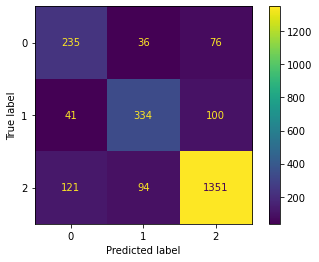

In [29]:
# Plotting confusion matrix
plot_confusion_matrix(xgbmodel_pipe, X_test_toframe,
                      y_test);

In [107]:
# Used the CountVectorizer to pinpoint important feature names
xgbmodel_pipe['preprocessor'].transformers_[0][1].named_steps['vec'].get_feature_names()

11868

In [92]:
# Feature names to be used on feauture importance graph
column_names = ['result', 'weak', 'fall', 'conference', 'bullish', 'jump', 'presentation', 'beat', 'raise', 'declare']

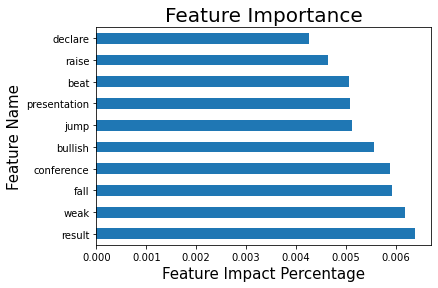

In [93]:
# Plotting Feature importances 
fig, ax = plt.subplots()
feature_imp_xgb = xgbmodel_pipe['xgb'].feature_importances_
feat_imp_series_xgb = pd.Series(feature_imp_xgb).sort_values(ascending = True)
feat_imp_series_xgb.nlargest(10).plot(kind = 'barh')
ax.set_yticklabels(column_names)
ax.set_title('Feature Importance', fontsize = 20)
ax.set_ylabel('Feature Name', fontsize = 15)
ax.set_xlabel('Feature Impact Percentage', fontsize = 15);

**Feature importance percentage is so low because there are over 11,000 features.**

## Evaluation

- The best model is the XGBoost classifier with an overall f1_weighted score of **81**%
- I chose the f1_weighted score as the overall metric performance because we want to take into account of the class imbalance
- It takes in the f1 score for each label and returns the average considering the porportion of each label in the dataset
- In the case of the stake holder who is trying to get an edge on other investors it is important to have an average of the false positives and the the false negatives rather than just one. 
- The error of false positive and a false negative of the model to an investor could make them make a poor decision investing equally
    - Which is why it is important to use f1
- Overall I dont think this model is good enough to use in the real world as it has some issues identifying the bullish and bearish labels. 